In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20]
lr = 0.001
num_epochs = 5000
activation = nn.Tanh()

In [3]:
class BurgersPINN(nn.Module):
    def __init__(self, layers):
        super(BurgersPINN, self).__init__()
        self.layers = layers
        self.net = self.build_network()
    def build_network(self):
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i+1]))
            if i != len(self.layers) - 2:
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)
    def forward(self, t, x):
        X = torch.cat([x, t], dim=1)
        u = self.net(X)
        return u

AttributeError: module 'torch.nn' has no attribute 'module'

In [4]:
viscosity_constant = (0.01/np.pi)

def burgers_residual(pred, t, x):
    u_t = torch.autograd.grad(inputs=t, outputs=pred, grad_outputs=torch.zeros_like(pred), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(inputs=x, outputs=pred, grad_outputs=torch.zeros_like(pred), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(inputs=x, outputs=u_x, grad_outputs=torch.zeros_like(u_x), create_graph=True, retain_graph=True)[0]
    return u_t + (pred * u_x) - (viscosity_constant * u_xx)

def random_domain(num_samples, t_range, x_range):
    t_min, t_max = t_range
    x_min, x_max = x_range
    t_random = np.random.uniform(t_min, t_max, size=(num_samples, 1))
    x_random = np.random.uniform(x_min, x_max, size=(num_samples, 1))
    return torch.tensor(t_random, dtype=torch.float32), torch.tensor(x_random, dtype=torch.float32)

def random_boundary(num_samples, initial_to_boundary_ratio, t_range, x_range):
    num_initial = int(initial_to_boundary_ratio * num_samples)
    num_boundary = num_samples - num_initial
    t_min, t_max = t_range

    # Generate initial condition samples
    t_initial = torch.zeros(size=(num_initial, 1))
    x_initial = torch.zeros(size=(num_initial, 1)).uniform_(*x_range)
    u_initial = -torch.sin(np.pi * x_initial)

    # Generate boundary condition samples
    t_boundary = torch.zeros(size=(num_boundary, 1)).uniform_(*t_range)

    # We assume x_range = (-1, 1) here
    x_boundary = 2 * torch.randint(0, 2, size=(num_boundary, 1)) - 1
    u_boundary = np.zeros((num_boundary, 1))

    return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
           torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)
    

NameError: name 'np' is not defined

In [5]:
model = BurgersPINN(layers=layers)
optimizer = optim.Adam(model.parameters(), lr=lr)
boundary_criterion = nn.MSELoss()
initial_criterion = nn.MSELoss()
domain_criterion = nn.MSELoss()

NameError: name 'PINN' is not defined

In [6]:
x_range, t_range = [-1, 1], [0, 0.5]
loss_history = []
domain_loss_history = []
initial_loss_history = []
boundary_loss_history = []

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    domain_t, domain_x = random_domain(3000, t_range, x_range)
    initial_t, initial_x, initial_u, boundary_t, boundary_x, boundary_u = random_boundary(1000, 0.75, t_range, x_range)

    domain_prediction = model(domain_t, domain_x)
    initial_prediction = model(initial_t, initial_x)
    boundary_prediction = model(boundary_t, boundary_x)

    domain_loss = domain_criterion(domain_prediction, torch.zeros_like(domain_prediction))
    initial_loss = initial_criterion(initial_prediction, initial_u)
    boundary_loss = boundary_criterion(boundary_prediction, boundary_u)

    loss = (domain_loss + initial_loss + boundary_loss)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    domain_loss_history.append(domain_loss.item())
    initial_loss_history.append(initial_loss.item())
    boundary_loss_history.append(boundary_loss.item())
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([750, 1])) that is different to the input size (torch.Size([750, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/nn/modules/lo

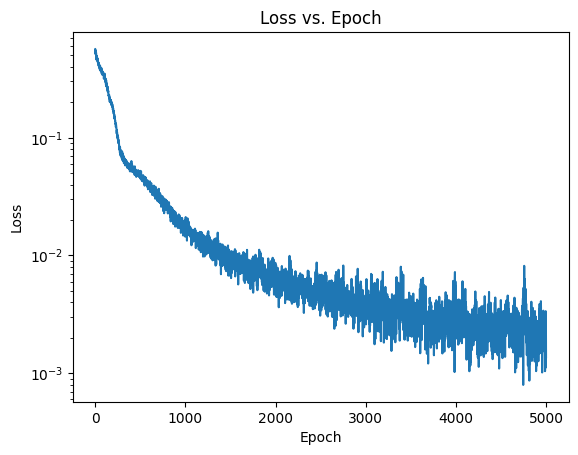

In [7]:
# Plot the loss history
plt.figure()
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch')
plt.show()

In [7]:
torch.save(model.state_dict(), "Burgers.pth")

In [8]:
# model = BurgersPINN(layers=layers)
# model.load_state_dict(torch.load("/work/Burgers.pth"))
# model.eval()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=10bedb5b-3713-4aa3-bd35-83eed005533b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>